In [1]:
# import pandas as pd
import cudf as pd
from tqdm.auto import tqdm

In [2]:
def import_labelled_data(path="data/labelled/data.json"):
    data = pd.read_json(path, encoding="latin-1")
    return data


print("Loading data...")

data = import_labelled_data(
    path="../../data/level-0.5/data.json"
)

print("Data loaded.")

data = data.sample(frac=1).reset_index(drop=True)

# data = data.sample(2500)

data.info()

Loading data...


/workspace/GreyLit/venv/lib/python3.10/site-packages/cudf/io/json.py:108: UserWarning: Using CPU via Pandas to read JSON dataset, this may be GPU accelerated in the future
  warnings.warn(


Data loaded.
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 19284 entries, 0 to 19283
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   url           19284 non-null  object
 1   text          19284 non-null  object
 2   relevance     19284 non-null  object
 3   multiclasses  19284 non-null  list
dtypes: list(1), object(3)
memory usage: 1.3+ GB


In [3]:
def train_test_split(x, y=None, test_size=0.2,shuffle=False):
    split = int(len(x) * (1 - test_size))
    xTrain, xTest = x.iloc[:split], x.iloc[split:]
    if y is not None:
        yTrain, yTest = y.iloc[:split], y.iloc[split:]
        return xTrain, xTest, yTrain, yTest
    return xTrain, xTest


trainData, testData = train_test_split(data, test_size=0.2)

In [4]:
trainData.head()

,url,text,relevance,multiclasses
0,https://products.z-wavealliance.org/ProductMan...,™ ELEMENT THERMOSTAT USER GUIDE Welcome ™ The ...,irrelevant,[]
1,https://region8.bfar.da.gov.ph/wp-content/uplo...,re Agricultu of ror Delortment materiars 7 oth...,irrelevant,[]
2,https://doe.gov.ph/sites/default/files/pdf/iss...,IMEM Implementing Rules Interim Mindanao Elect...,irrelevant,[]
3,https://www.conservationevidence.com/individua...,(Summarised by: William Morgan)A replicated st...,relevant,[Reptiles]
4,https://www.deloitte.com/content/dam/assets-sh...,State and local government IT leaders often fa...,irrelevant,[]


In [5]:
from cuML_LogisticRegressionClassifier import LogisticRegressionClassifier

# roughly 47s for 2500 articles
print('Estimated time to train on full dataset: ', 47 / 2500 * len(data), ' seconds')

logistic = LogisticRegressionClassifier()
logistic.train(trainData)

Estimated time to train on full dataset:  362.5392  seconds
Vectorizing complete.
Training complete.


In [6]:
from cupy import unique

def precision_score(y_true, y_pred, average: str = 'macro', zero_division = 0) -> float:
    if average == 'macro':
        precis = 0
        for i in unique(y_true):
            tp = sum((y_true == i) & (y_pred == i))
            fp = sum((y_true != i) & (y_pred == i))
            if tp + fp == 0:
                print(f'Zero Division: Class {i} was never predicted.')
                tp, fp = 0,1
            precis += tp / (tp + fp)

        return precis / len(unique(y_true))

    elif average == 'micro':
        tp = sum(y_true == y_pred)
        fp = sum(y_true != y_pred)
        if tp + fp == 0:
            print(f'Zero Division: Class {i} was never predicted.')
            tp, fp = 0,1
        return tp / (tp + fp)

def recall_score(y_true, y_pred, average: str = 'macro', zero_division = 0) -> float:
    if average == 'macro':
        recall = 0
        for i in unique(y_true):
            tp = sum((y_true == i) & (y_pred == i))
            fn = sum((y_true == i) & (y_pred != i))
            if tp + fn == 0:
                print(f'Zero Division: Class {i} never appeared in the test set.')
                tp, fn = 0,1
            recall += tp / (tp + fn)

        return recall / len(unique(y_true))

    elif average == 'micro':
        tp = sum(y_true == y_pred)
        fn = sum(y_true != y_pred)
        if tp + fn == 0:
            print(f'Zero Division: Class {i} never appeared in the test set.')
            tp, fn = 0,1
        return tp / (tp + fn)

def f1_score(y_true, y_pred, average: str = 'macro', zero_division = 0) -> float:
    if average == 'macro':
        precis = precision_score(y_true, y_pred, average, zero_division)
        recall = recall_score(y_true, y_pred, average, zero_division)
        return 2 * (precis * recall) / (precis + recall)
    elif average == 'micro':
        precis = precision_score(y_true, y_pred, average, zero_division)
        recall = recall_score(y_true, y_pred, average, zero_division)
        return 2 * (precis * recall) / (precis + recall)

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score

def calculate_metrics(trueYInts, predYInts, predYProbabilities):
    return {
            "accuracy": accuracy_score(trueYInts, predYInts),
            "f1": f1_score(trueYInts, predYInts, average='macro',zero_division=0),
            "precision": precision_score(trueYInts, predYInts, average='macro',zero_division=0),
            "confusion_matrix": confusion_matrix(trueYInts, predYInts),
            "predictions": predYInts,
            "probabilities": predYProbabilities
        }


def format_output(results):
    print(f"Accuracy: {results['accuracy']} \t F1: {results['f1']} \t Precision: {results['precision']} \t")
    print("\n\n")

In [8]:
def eval(classifier):
    predYInts, predYProbabilities = classifier.predict_threshold(testData, threshold=0.5)
    trueYInts = (testData['relevance']=='relevant').astype('int32').to_numpy()
    predYInts = predYInts.astype('int32').get()
    predYProbabilities = predYProbabilities.get()

    return trueYInts, predYInts, predYProbabilities


In [9]:
trueYInts, predYInts, predYProbabilities = eval(logistic)


In [19]:
len(testData)

3857

In [20]:
print('Files processed per second: ', 3857 / 51)

Files processed per second:  75.62745098039215


In [10]:
testData = testData.to_pandas()

In [11]:
textPreds = predYInts.astype('str')

textPreds[textPreds == '0'] = 'irrelevant'
textPreds[textPreds == '1'] = 'relevant'

testData['predictions'] = textPreds


In [12]:
type(trueYInts), type(predYInts), type(predYProbabilities)

(numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [13]:
results = calculate_metrics(trueYInts, predYInts, predYProbabilities)

format_output(results)

Accuracy: 0.9953331604874255 	 F1: 0.99528569915283 	 Precision: 0.9955529104195711 	





In [18]:
testData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3857 entries, 15427 to 19283
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   url           3857 non-null   object
 1   text          3857 non-null   object
 2   relevance     3857 non-null   object
 3   multiclasses  3857 non-null   object
 4   predictions   3857 non-null   object
dtypes: object(5)
memory usage: 150.8+ KB


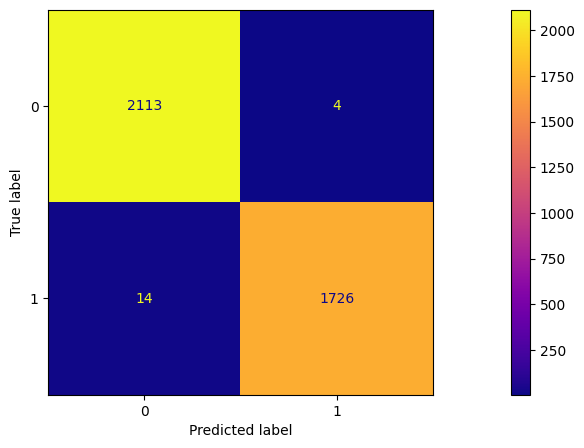

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axs = plt.subplots(1, 1, figsize=(20, 5))


confusion = confusion_matrix(testData['relevance'], testData['predictions'])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion)
disp.plot(ax=axs, cmap='plasma')

plt.show()



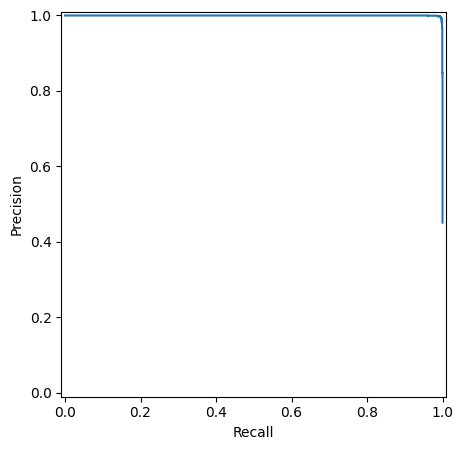

In [15]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

precision, recall, thresholds = precision_recall_curve(trueYInts, predYProbabilities[:,1])

fig, axs = plt.subplots(1, 1, figsize=(20, 5))

disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot(ax=axs)

plt.show()


In [16]:
# save logistic regression model

import pickle
import os

with open('models/LogisticRegression.pkl', 'wb') as f:
    pickle.dump(logistic, f)



In [17]:
# from numpy import arange
# thresholds = list(arange(0.49, 0.53, 0.01))
# thresholds.sort()


# yTrue = trainData['relevance'].apply(lambda x: True if x == 'relevant' else False)

# precisions = []
# recalls = []
# accuracies = []

# for threshold in tqdm(thresholds):
#     yPred = logistic.predict_threshold(trainData, threshold)
#     precisions.append(precision_score(yTrue, yPred, average='macro',zero_division=0))
#     recalls.append(f1_score(yTrue, yPred, average='macro',zero_division=0))
#     accuracies.append(accuracy_score(yTrue, yPred))

# plt.plot(thresholds, precisions, label='Precision')
# plt.plot(thresholds, recalls, label='Recall')
# plt.plot(thresholds, accuracies, label='Accuracy')
# plt.xlabel('Threshold')
# plt.ylabel('Score')
# plt.legend()

# plt.show()